In [23]:
from utils.head import ensemble, end2end
from utils.dataset import load_compiled_data, aircraft_camera_data
from utils.training import train_aux, train_de
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchinfo
import pickle as pkl

from matplotlib.lines import Line2D
import time
import os
import numpy as np

device = torch.device('cuda:0')

offset = [[19.75390625, 248.5, 9.0, 5.5], [5.056640625, 248.5, 10.109375, 4.5]]
divider = [[1895.24609375, 395.75, 175.25, 151.0],[1909.443359375, 396.5, 172.640625, 83.5]]

trajectory_threshold = [800, 700]

train_data = load_compiled_data(ts=[1,2,5], ws=[1], rs=[
                                1, 2], offset=offset, divider=divider, trajectory_threshold=trajectory_threshold, device=device, verbose=False)
test_data = load_compiled_data(ts=[1,2,5], ws=[1], rs=[
                               3], offset=offset, divider=divider, trajectory_threshold=trajectory_threshold, device=device, verbose=False)
init_list =['kaiming']
desc = 'big_dataset'

In [24]:
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#8d3ed2']

# Frames from Video

## Barely visible aircraft in low visibility conditions:

In [25]:
t = 3 # Time - 5
w = 4 # Weather - 5
r = 1 # Runs - 3

data_indexes = [1,2] # Camera 1 & 2
touchdown_target_lat_lon = [1.3541354199301814, 103.97961848373048] # WSSS 02L Runway
dataset_directory = "/media/gabriel/DATA/dataset"
data_sources = [[f'{dataset_directory}/t{t}/r{r}/w{w}/{data_index}/data.pkl', f'{dataset_directory}/t{t}/r{r}/w{w}/{data_index}/video.avi'] for data_index in data_indexes]

# Dataset Class Initialization
acd = aircraft_camera_data(data_sources = data_sources, touchdown_target_lat_lon = touchdown_target_lat_lon)

Current Distance: 3.09 nm


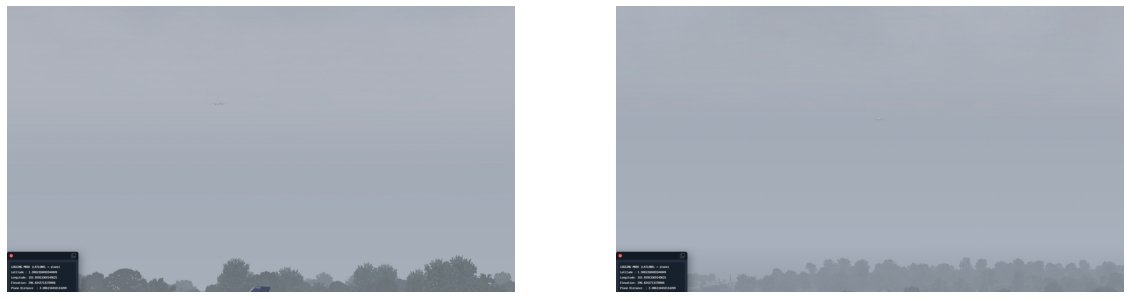

In [26]:
n = 4500
fig, ax = acd.vis_frame(n)
print(f'Current Distance: {acd.get_current_dtt(n):.2f} nm')

In [35]:
fig.savefig("images/foggy_frame.png", dpi=300)

## Inference on Frame

In [32]:
offset = [[19.75390625, 248.5, 9.0, 5.5], [5.056640625, 248.5, 10.109375, 4.5]]
divider = [[1895.24609375, 395.75, 175.25, 151.0],[1909.443359375, 396.5, 172.640625, 83.5]]
model = end2end('models/config/model_m_m.yaml', model_state_dict='models/head/final_training_m_m.pt', offset = offset, divider = divider, device = device)

Input_Reg Aux DE Loaded


Time Profile:

Object Detector    : 28.45 ms
Preprocessing      : 0.31 ms
Distance Estimator : 0.92 ms

Total Time         : 29.68 ms (33.68864757192655 FPS)
            
Error: 0.00 nm


(<Figure size 1440x720 with 2 Axes>,
 array([<AxesSubplot: >, <AxesSubplot: >], dtype=object))

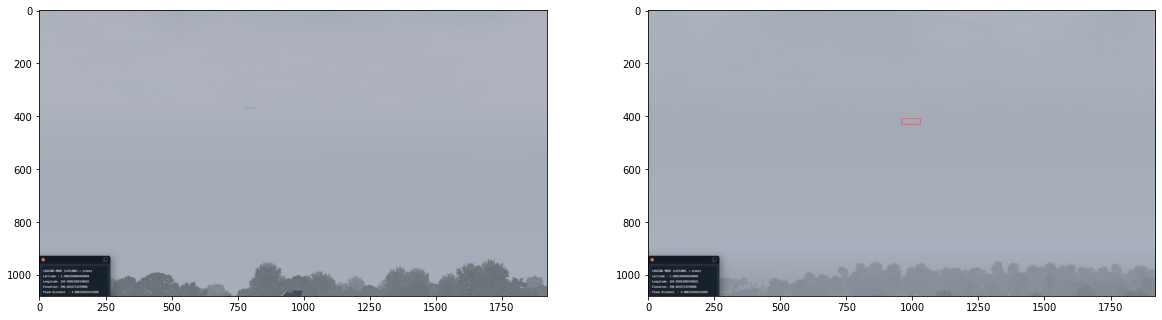

In [38]:
img = acd.get_frame_from_video(n, size = (1280, 1920), batch_size = 1).cuda()
box, score, pred = model.single_infer(img)
gt = acd.get_current_dtt(n)

print(f'Error: {abs(pred - gt):.2f} nm')
model.vis(img, box, score, pred, gt)

In [39]:
fig.savefig("images/foggy_frame_inference.png", dpi=300)

## Frame Trajectory

In [40]:
t = 2 # Time - 5
w = 1 # Weather - 5
r = 1 # Runs - 3

data_indexes = [1,2] # Camera 1 & 2
touchdown_target_lat_lon = [1.3541354199301814, 103.97961848373048] # WSSS 02L Runway
dataset_directory = "/media/gabriel/DATA/dataset"
data_sources = [[f'{dataset_directory}/t{t}/r{r}/w{w}/{data_index}/data.pkl', f'{dataset_directory}/t{t}/r{r}/w{w}/{data_index}/video.avi'] for data_index in data_indexes]

# Dataset Class Initialization
acd = aircraft_camera_data(data_sources = data_sources, touchdown_target_lat_lon = touchdown_target_lat_lon)
trajectory_data = load_compiled_data(ts=[t], ws=[w], rs=[r], inference_mode=True, verbose=False)['x'].numpy()

In [41]:
offset = [[19.75390625, 248.5, 9.0, 5.5], [5.056640625, 248.5, 10.109375, 4.5]]
divider = [[1895.24609375, 395.75, 175.25, 151.0],[1909.443359375, 396.5, 172.640625, 83.5]]
model = end2end('models/config/model_m_m.yaml', model_state_dict='models/head/final_training_m_m.pt', offset = offset, divider = divider, device = device)

Input_Reg Aux DE Loaded


7.081282883293668

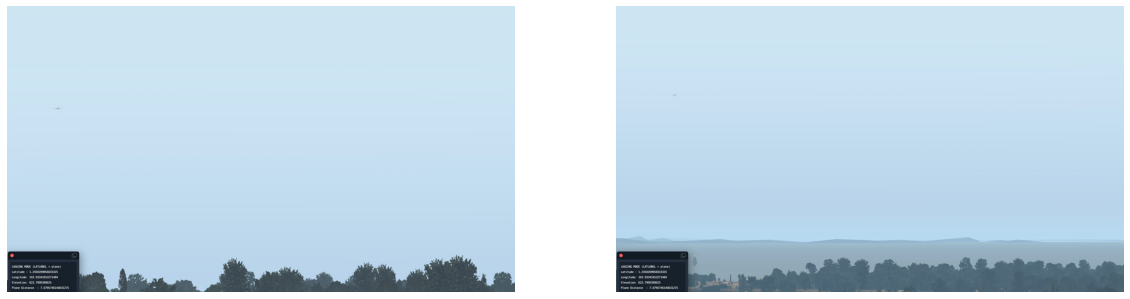

In [20]:
n=2000
acd.vis_frame(n)
acd.get_current_dtt(n)

Time Profile:

Object Detector    : 30.19 ms
Preprocessing      : 0.38 ms
Distance Estimator : 1.12 ms

Total Time         : 31.68 ms (31.561274399145184 FPS)
            


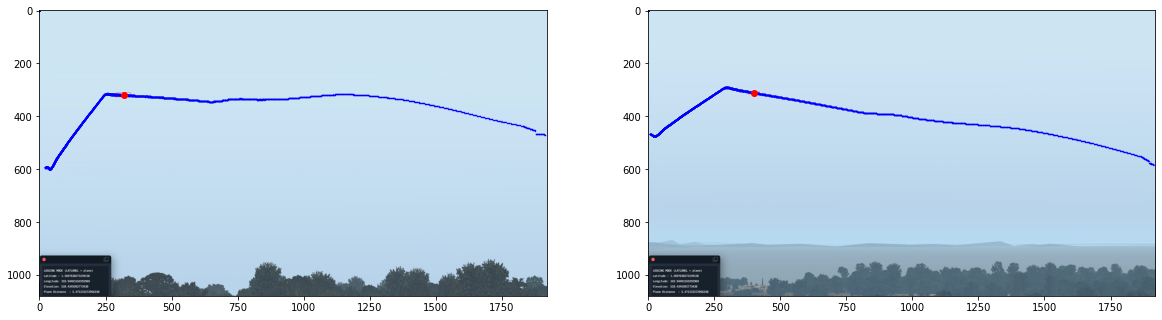

In [42]:
n=3000
img = acd.get_frame_from_video(n, size = (1280, 1920), batch_size = 1).cuda()
box, score, pred = model.single_infer(img)
fig, ax = plt.subplots(1, 2,figsize = (20, 20))
fig, ax = model.vis(img, box, fig=fig, ax=ax)
for i in range(len(img[0])):
    ax[i].scatter(trajectory_data[i, :, 0], trajectory_data[i, :, 1], s = 0.1, c='b')
    ax[i].scatter(trajectory_data[i, n, 0], trajectory_data[i, n, 1], c='r')
    #ax[0][0].scatter(((box[0][0] + box[0][2])/2).cpu().numpy(), ((box[0][1] + box[0][3])/2).cpu().numpy(), s = 100)

In [43]:
fig.savefig("images/simulation_trajectory.png", dpi=300)

# "Auto" Training Mode

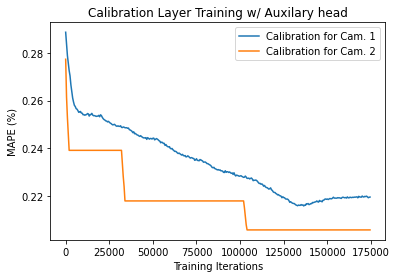

In [44]:
with open('models/head/demo_aux_training_log.pkl', 'rb') as f:
    training_log = pkl.load(f)

fig, ax = plt.subplots(1,1)
ax.set_title('Calibration Layer Training w/ Auxilary head')
ax.set_xlabel('Training Iterations')
ax.set_ylabel('MAPE (%)')
plt.plot(np.arange(training_log[1][55:, 0].shape[0]) * 500, training_log[1][55:, 0],  label="Calibration for Cam. 1")
plt.plot(np.arange(training_log[1][55:, 0].shape[0]) * 500, training_log[1][55:, 1],  label="Calibration for Cam. 2")
plt.legend(loc="upper right")

In [46]:
fig.savefig("images/adaptive_training.png", dpi=300)

# Percentange of Missing Detections in any camera

In [353]:
temp = load_compiled_data(ts=[1,2,3,4,5], ws=[1,2,3,4,5], rs=[1, 2, 3], inference_mode = True)
ff_both = torch.all(torch.any(temp['x'] != 0, dim = 2), dim = 0)
ff_any = torch.any(torch.any(temp['x'] != 0, dim = 2), dim = 0)
print(f"Loss Data: { (1 - (temp['x'][:, ff_both].shape[1] / temp['x'][:, ff_any].shape[1])) * 100} %")

Loss Data: 40.448382405905505 %


# Single vs Multi-View Model Prediction

In [47]:
model_type = 'm_m'
model = ensemble(f'models/config/model_{model_type}.yaml', model_state_dict=f'models/head/final_training_m_m.pt', device = device)

test_data = load_compiled_data(ts=[1,2,5], ws=[1], rs=[
                               3], offset=offset, divider=divider, trajectory_threshold=trajectory_threshold, inference_mode = True, device=device, verbose=False)

f_single = torch.logical_xor(torch.any(torch.any(test_data['x'] != 0, dim = 2), dim = 0), torch.all(torch.any(test_data['x'] != 0, dim = 2), dim = 0))
f_both = torch.all(torch.any(test_data['x'] != 0, dim = 2), dim = 0)
camera_single = model(test_data['x'][:, f_single]).cpu().numpy()
camera_both = model(test_data['x'][:, f_both]).cpu().numpy()

gt_both = test_data['y'][0, f_both, 0].cpu().numpy()
f_sort = np.argsort(gt_both)
gt_both = gt_both[f_sort]
err_cam_both = ((camera_both[f_sort]-gt_both)*100/gt_both)

gt_single = test_data['y'][0, f_single, 0].cpu().numpy()
f_sort = np.argsort(gt_single)
gt_single = gt_single[f_sort]
err_cam_single = ((camera_single[f_sort]-gt_single)*100/gt_single)

Input_Reg Aux DE Loaded


  0%|          | 0/5700 [00:00<?, ?it/s]

  0%|          | 0/10447 [00:00<?, ?it/s]

In [48]:
print(f'MAPE Multi : {abs(err_cam_both).mean():.4f} %\nMAPE Single: {abs(err_cam_single).mean():.4f} %')

MAPE Multi : 0.1543 %
MAPE Single: 0.2810 %


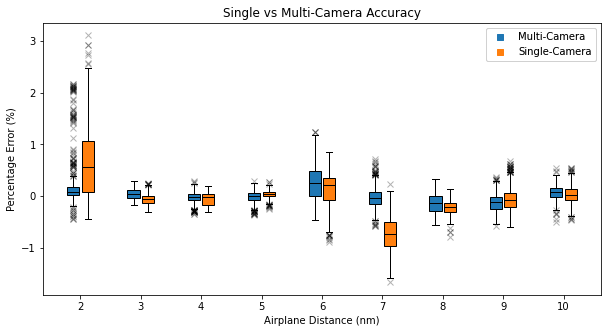

In [49]:
key_distances = np.array([2,3,4,5,6,7,8,9,10])
f_per_dist_boths = [np.logical_and(gt_both*10<=(i+0.5), gt_both*10>(i-0.5)) for i in key_distances]
f_per_dist_singles = [np.logical_and(gt_single*10<=(i+0.5), gt_single*10>(i-0.5)) for i in key_distances]

fig, ax = plt.subplots(1,1,figsize=(10,5))
bps = ax.boxplot([err_cam_single[i] for i in f_per_dist_singles], widths=0.2, patch_artist = True, positions=key_distances+0.12)
bpb = ax.boxplot([err_cam_both[i] for i in f_per_dist_boths], widths=0.2, patch_artist = True, positions=key_distances-0.12)

ax.set_title('Single vs Multi-Camera Accuracy')
ax.set_xlabel('Airplane Distance (nm)')
ax.set_ylabel('Percentage Error (%)')

for flier in bpb['fliers']:
    flier.set(marker ='x',
              color =colors[0],
              alpha = 0.3)
    
for patch in bpb['boxes']:
    patch.set_facecolor(colors[0])

for median in bpb['medians']:
    median.set(color ='black',
               linewidth = 1)
    
for flier in bps['fliers']:
    flier.set(marker ='x',
              color =colors[1],
              alpha = 0.3)
    
for patch in bps['boxes']:
    patch.set_facecolor(colors[1])

for median in bps['medians']:
    median.set(color ='black',
               linewidth = 1)

ax.set_xticks(key_distances)
ax.set_xticklabels(key_distances)

custom_lines_1 = [Line2D([0], [0], color=colors[0], lw=0, marker='s'),
                Line2D([0], [0], color=colors[1], lw=0, marker='s')]

legend1 = ax.legend(custom_lines_1, ['Multi-Camera', 'Single-Camera'], loc ='upper right')
ax.add_artist(legend1)

In [51]:
fig.savefig("images/single_vs_multicamera.png", dpi=300)

# Effect of Lighting (Time of day) on Accuracy

In [52]:
model_type = 'm_m'
model = ensemble(f'models/config/model_{model_type}.yaml', model_state_dict=f'models/head/final_training_m_m.pt', device = device)
time_variation_dataset = [load_compiled_data(ts=[i], ws=[1], rs=[1,2,3], offset=offset, divider=divider, trajectory_threshold=trajectory_threshold, inference_mode = True, device=device, verbose=False) for i in range(1,6)]
pred = [model(i['x']) for i in time_variation_dataset]
ff_available = [torch.any(torch.any(i['x'] != 0, dim = 2), dim = 0) for i in time_variation_dataset]
err = [((pred[i] - time_variation_dataset[i]['y'][0, :, 0])*100/time_variation_dataset[i]['y'][0, :, 0])[ff_available[i]].cpu().numpy() for i in range(len(time_variation_dataset))]

Input_Reg Aux DE Loaded


  0%|          | 0/19516 [00:00<?, ?it/s]

  0%|          | 0/20128 [00:00<?, ?it/s]

  0%|          | 0/19537 [00:00<?, ?it/s]

  0%|          | 0/20375 [00:00<?, ?it/s]

  0%|          | 0/20259 [00:00<?, ?it/s]

In [53]:
print(f'MAPE at every lighting condition: {[round(abs(i).mean(), 4) for i in err]:}')
print(f'STD  at every lighting condition: {[round(abs(i).std(), 4) for i in err]:}')

MAPE at every lighting condition: [0.1615, 0.2126, 0.205, 0.2422, 0.1744]
STD  at every lighting condition: [0.25, 0.2867, 0.2626, 0.2727, 0.2069]


(-1.0, 1.0)

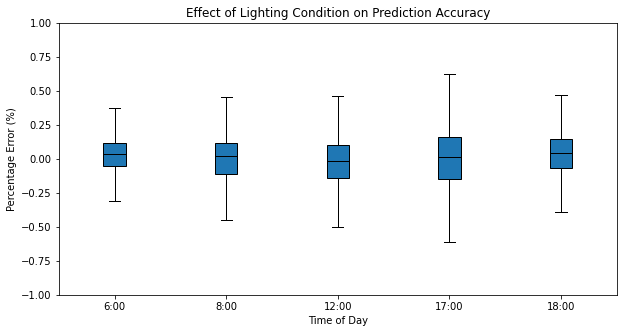

In [55]:
fig, ax = plt.subplots(1,1,figsize=(10,5))
bp = ax.boxplot(err, widths=0.2, patch_artist = True)

ax.set_title('Effect of Lighting Condition on Prediction Accuracy')
ax.set_xlabel('Time of Day')
ax.set_ylabel('Percentage Error (%)')
    
for flier in bp['fliers']:
    flier.set(marker ='x',
              color =colors[0],
              alpha = 0.0)
    
for patch in bp['boxes']:
    patch.set_facecolor(colors[0])

for median in bp['medians']:
    median.set(color ='black',
               linewidth = 1)

ax.set_xticklabels(['6:00', '8:00', '12:00', '17:00', '18:00'])
ax.set_ylim(-1,1)

In [56]:
fig.savefig("images/time_vs_accuracy.png", dpi=300)

# Effect on Weather on Accuracy

In [57]:
model_type = 'm_m'
model = ensemble(f'models/config/model_{model_type}.yaml', model_state_dict=f'models/head/final_training_m_m.pt', device = device)
weather_variation_dataset = [load_compiled_data(ts=[2], ws=[i], rs=[1,2,3], offset=offset, divider=divider, trajectory_threshold=trajectory_threshold, inference_mode = True, device=device, verbose=False) for i in [1,3,4,5]]
pred = [model(i['x']) for i in weather_variation_dataset]
ff_available = [torch.any(torch.any(i['x'] != 0, dim = 2), dim = 0) for i in weather_variation_dataset]
gt = [weather_variation_dataset[weather]['y'][0, :, 0][ff_available[weather]].cpu().numpy() for weather in range(len(weather_variation_dataset))]
err = [((pred[i][ff_available[i]].cpu().numpy() - gt[i])*100/gt[i]) for i in range(len(weather_variation_dataset))]

Input_Reg Aux DE Loaded


  0%|          | 0/20128 [00:00<?, ?it/s]

  0%|          | 0/19591 [00:00<?, ?it/s]

  0%|          | 0/20128 [00:00<?, ?it/s]

  0%|          | 0/20128 [00:00<?, ?it/s]

In [58]:
print(f'MAPE at every weather condition: {[round(abs(i).mean(), 4) for i in err]:}')
print(f'STD  at every weather condition: {[round(abs(i).std(), 4) for i in err]:}')

MAPE at every weather condition: [0.2126, 0.3456, 0.1622, 0.2277]
STD  at every weather condition: [0.2867, 0.624, 0.2345, 0.3055]


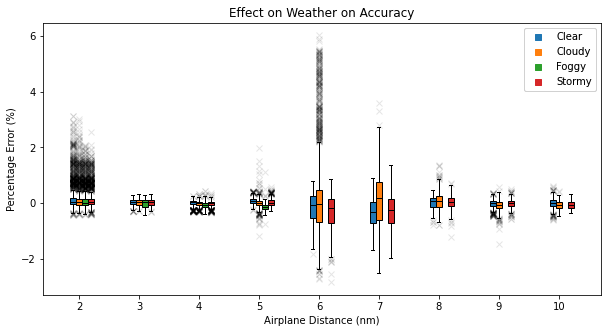

In [60]:
key_distances = np.array([2,3,4,5,6,7,8,9,10])
err_per_dist = [[err[weather][np.logical_and(gt[weather]*10<=(i+0.5), gt[weather]*10>(i-0.5))] for i in key_distances] for weather in range(len(err))]

fig, ax = plt.subplots(1,1,figsize=(10,5))
bps = []
for i in range(len(err_per_dist)):
    bps.append(ax.boxplot(err_per_dist[i], widths=0.1, patch_artist = True, positions=key_distances-(0.1*(len(err_per_dist)-i) - 0.3)))

for i in range(len(bps)):
    for flier in bps[i]['fliers']:
        flier.set(marker ='x',
                  color =colors[i],
                  alpha = 0.1)

    for patch in bps[i]['boxes']:
        patch.set_facecolor(colors[i])

    for median in bps[i]['medians']:
        median.set(color ='black',
                   linewidth = 1)
    
ax.set_title('Effect on Weather on Accuracy')
ax.set_xlabel('Airplane Distance (nm)')
ax.set_ylabel('Percentage Error (%)')


ax.set_xticks(key_distances)
ax.set_xticklabels(key_distances)

custom_lines_1 = [Line2D([0], [0], color=i, lw=0, marker='s') for i in colors]

legend1 = ax.legend(custom_lines_1, ['Clear', 'Cloudy', 'Foggy', 'Stormy'], loc ='upper right')
ax.add_artist(legend1)
#ax.set_ylim(-3,3)

In [61]:
fig.savefig("images/weather_vs_accuracy.png", dpi=300)

# Architecture Search

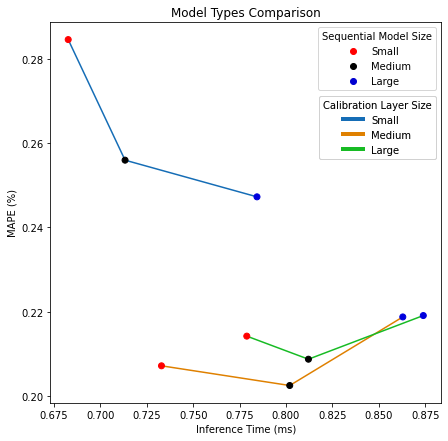

In [62]:
test_data = load_compiled_data(ts=[2,3,4], ws=[1], rs=[
                               3], offset=offset, divider=divider, trajectory_threshold=trajectory_threshold, inference_mode = True, device=device, verbose=False)
ff = torch.any(torch.all(test_data['x'] != 0, dim = 2), dim = 0)
init = init_list[0]
with open(f'output/distance_estimator/{init}_{desc}_as.pkl', 'rb') as f:
    output_dict, time_dict = pkl.load(f)
best_mape = {}
for i in output_dict.keys():
    best_mape[i] = torch.mean(torch.mean(abs(output_dict[i].cuda() - test_data['y'][0, ff, 0]) * 100 / test_data['y'][0, ff, 0], axis = 1)).item()
output_s = [best_mape[i] for i in ['s_s', 's_m', 's_l']]
output_m = [best_mape[i] for i in ['m_s', 'm_m', 'm_l']]
output_l = [best_mape[i] for i in ['l_s', 'l_m', 'l_l']]
time_s = [time_dict[model_type] * 1000 for model_type in ['s_s', 's_m', 's_l']]
time_m = [time_dict[model_type] * 1000 for model_type in ['m_s', 'm_m', 'm_l']]
time_l = [time_dict[model_type] * 1000 for model_type in ['l_s', 'l_m', 'l_l']]

fig, ax = plt.subplots(1,1, figsize = (7, 7))
cmap1 = plt.cm.flag
cmap2 = plt.cm.viridis
ax.scatter(time_s, output_s, c=[0,1,2], vmin=0, vmax=20, cmap = 'flag', zorder = 2)
ax.scatter(time_m, output_m, c=[0,1,2], vmin=0, vmax=20, cmap = 'flag', zorder = 2)
ax.scatter(time_l, output_l, c=[0,1,2], vmin=0, vmax=20, cmap = 'flag', zorder = 2)

ax.set_title("Model Types Comparison")
ax.set_ylabel('MAPE (%)')
ax.set_xlabel('Inference Time (ms)')

ax.plot(time_s, output_s, zorder = 1, c='#156DB6')
ax.plot(time_m, output_m, zorder = 1, c='#DF8000')
ax.plot(time_l, output_l, zorder = 1, c='#17BB24')


custom_lines_1 = [Line2D([0], [0], color=cmap1(0), lw=0, marker='o', markersize=6),
                Line2D([0], [0], color=cmap1(1000), lw=0, marker='o', markersize=6),
                Line2D([0], [0], color=cmap1(9), lw=0, marker='o', markersize=6)]

custom_lines_2 = [Line2D([0], [0], color='#156DB6', lw = 4),
                Line2D([0], [0], color='#DF8000', lw = 4),
                Line2D([0], [0], color='#17BB24', lw = 4)]


legend1 = ax.legend(custom_lines_1, ['Small', 'Medium', 'Large'], title= "Sequential Model Size", loc ='upper right')
ax.add_artist(legend1)
legend2 = ax.legend(custom_lines_2, ['Small', 'Medium', 'Large'], title="Calibration Layer Size", loc = 'upper center', bbox_to_anchor=[0.837, 0.82])
ax.add_artist(legend2)

In [63]:
fig.savefig("images/architecture_search.png", dpi=300)

In [136]:
import torchinfo
model = ensemble(f'models/config/model_{model_list[8]}.yaml', device=device, num_camera=2)
torchinfo.summary(model, input_size=(1,1,4))

  0%|          | 0/1 [00:00<?, ?it/s]

Layer (type:depth-idx)                   Output Shape              Param #
ensemble                                 [1]                       131,585
├─ModuleList: 1-1                        --                        198,656
│    └─Sequential: 2-1                   [1, 512]                  --
│    │    └─Linear: 3-1                  [1, 256]                  1,280
│    │    └─LeakyReLU: 3-2               [1, 256]                  --
│    │    └─Linear: 3-3                  [1, 256]                  65,792
│    │    └─LeakyReLU: 3-4               [1, 256]                  --
│    │    └─Linear: 3-5                  [1, 512]                  131,584
│    │    └─LeakyReLU: 3-6               [1, 512]                  --
├─Sequential: 1-2                        [1, 1]                    --
│    └─LSTM: 2-2                         [1, 1, 1024]              23,093,248
│    └─extract_tensor: 2-3               [1, 1024]                 --
│    └─Linear: 2-4                       [1, 512]      